In [6]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
from scipy.stats import skewnorm
from ll_xy import lonlat_to_xy
from scipy.stats import linregress, skew
import datetime
import string
import cartopy
import tools
import cartopy.crs as ccrs
import pandas as pd
from dateutil.relativedelta import relativedelta
alphabet_string = string.ascii_lowercase

pd.set_option("mode.chained_assignment", None)

dep_l = pickle.load(open('../pickles/line_depths_dict.p','rb'))
statistics = pickle.load(open('../pickles/statistics.p','rb'))

np_df = pickle.load(open('../pickles/NP_df.p','rb'))

In [2]:
bw = 2

bin_edges = np.arange(0,70,bw)

bin_centres = bin_edges[1:]

all_statistics = tools.get_statistics(np_df)


tiny_bin_edges = np.arange(-2.5,4,0.05)

np_fit = skewnorm.pdf(tiny_bin_edges,all_statistics['a'],all_statistics['loc'],all_statistics['scale'])

linear_prediction = np.array([0,np.max(np_df['mean'])])*all_statistics['CV']

/home/robbie/Dropbox/sub_km/notebooks/tools.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  CV = np.linalg.lstsq(np.array(df['mean'])[:, np.newaxis], df['std'])[0][0]


In [3]:
statistics['all']

{'a': 2.542562886886376,
 'loc': -1.1145255608199975,
 'scale': 1.497381943420248,
 'stats': 0.4169616718934025,
 'n': 33539}

In [4]:
def compare_magna(df,ax=None,impose_y = False,anno=False,season='all'):
    
    d = np.array(df['Snow Depth (cm)'])
    
    best_fit_params = skewnorm.fit((d-np.nanmean(d))/np.nanstd(d)), np.nanstd(d)

    bw = 5
    
    bin_edges = np.arange(0,81,bw)

    mean_magna = np.nanmean(df['Snow Depth (cm)'])

    ##################################################

    bc, ft = tools.depth_distribution_from_depth(mean_magna,bin_edges,statistics=statistics['all'])

    hist, bin_edges = np.histogram(np.array(df['Snow Depth (cm)']),bins=bin_edges, density=True)
    
    rmse = np.sqrt(np.mean(np.square(ft-(hist*bw))))

    rmse = np.round(rmse,decimals=3)

    if ax == None: fig, ax  = plt.subplots(1,1)
        
    ax.step([0]+list(bc+bw/2),[0]+list(ft),color='r',)
    ax.step([0]+list(bc+bw/2), [0]+list(hist*bw),color='b')
    
    alpha=0.5
    
    t = ax.bar(bc, hist*bw,
             width=bw,
             alpha=alpha,
             color='#1f77b4',
              label='Transect')

    m = ax.bar(bc, ft,
             width=bw,
             alpha=alpha,
             color='r',
              label='Model')
    
#     ax.legend(loc='center right')
    
    return(bc, hist*bw, ft, rmse, best_fit_params)

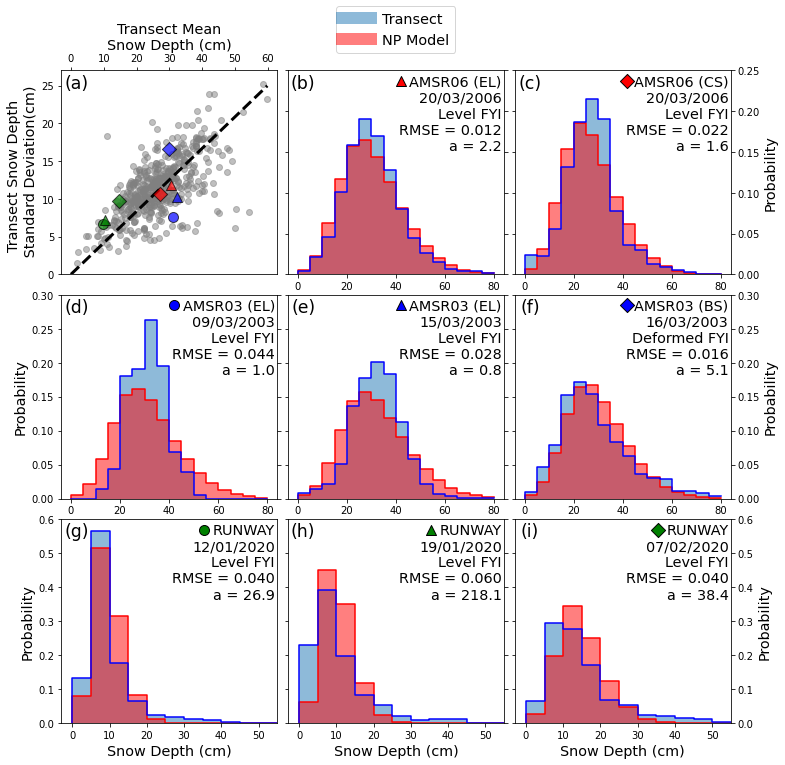

In [13]:
fig, axs = plt.subplots(3,3,figsize=(12,12))

ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9 = axs.reshape(-1)

###############

ax1.scatter(np_df['mean'], np_df['std'],marker='o',color='gray',alpha=0.5, label = 'NP Transects')
ax1.plot([0,np.max(np_df['mean'])], linear_prediction, color='k',lw=3, ls='--')

ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')

ax1.set_ylim(0,27)

ax1.set_ylabel('Transect Snow Depth \n Standard Deviation(cm)', fontsize='x-large')

ax1.set_xlabel('Transect Mean\nSnow Depth (cm)', fontsize='x-large')

#######################################

elson_paths = [
               '../AMSR snow depth/AMSRIce2006_Elson.xlsx',
#                '../AMSR snow depth/AMSRIce2006_Chukchi_rubble.xlsx',
               '../AMSR snow depth/AMSRIce2006_Chukchi_smooth.xlsx',
               '../AMSR snow depth/MP3Mar9Elson.xls',
               '../AMSR snow depth/GPSMagnaProbeMar15Elson.xls',
               '../AMSR snow depth/GPSMagnaProbe2Mar16Elson.xls',
                '../AMSR snow depth/mosaic_runway_20200112.xls',
                '../AMSR snow depth/mosaic_runway_20200119.xls',
               '../AMSR snow depth/mosaic_runway_20200207.xls',


               ]

dates = ['AMSR06 (EL)\n20/03/2006',
#          'AMSR06\n#Date',
         'AMSR06 (CS)\n20/03/2006',
         'AMSR03 (EL)\n09/03/2003',
         'AMSR03 (EL)\n15/03/2003',
         'AMSR03 (BS)\n16/03/2003',
         'RUNWAY\n12/01/2020',
         'RUNWAY\n19/01/2020',
         'RUNWAY\n07/02/2020']



ice_types = ['Level FYI',
#              'Rubble FYI', 
             'Level FYI',
             'Level FYI','Level FYI', 'Deformed FYI',
            'Level FYI', 'Level FYI','Level FYI',]
    


# #Top Legend

line1, = ax2.plot([], lw=12, label="Transect", color='#1f77b4',alpha=0.5,)
line2, = ax2.plot([], lw=12, label="NP Model", color='r',alpha=0.5,)

first_legend = ax2.legend(handles=[line1,line2],
                          loc='center',
                          fontsize='x-large',
                          bbox_to_anchor=(0.5,1.2))

lax = ax2.add_artist(first_legend)


###

elson_ratios = []
rmses = []
skews = []

for ax, epath, date, it in zip(axs.reshape(-1)[1:],
                                     elson_paths,
                                     dates,
                                     ice_types,
                              ):
    
    
    df = pd.read_excel(epath)
    
    sd = np.array(df['Snow Depth (cm)'])
    mean = np.nanmean(sd)
    std = np.nanstd(sd)
    norm = (sd-mean)/std
    skews.append( skew(norm) )
    
    elson_ratios.append( (mean, 
                           std) )

    _,_,_,rmse,best_fit_params = compare_magna(df, ax=ax, impose_y=True,anno=False,season='all')   
    
    skew_param = np.round(best_fit_params[0][0],decimals=1)
    
    ax.set_xlabel('Snow Depth (cm)', fontsize='x-large')
    ax.set_ylabel('Probability', fontsize='x-large')
    
    ax.annotate(xy=(0.99,0.98),xycoords='axes fraction',
                text=f'{date}\n{it}\nRMSE = {rmse:.3f}\na = {skew_param}', fontsize='x-large',
                ha='right',va='top')
    

####

for i, marker, date, color in zip(range(9),
                                 ['^','D','o','^','D','o','^','D'],
                                 dates,
                                 ['r','r','b','b','b','g','g','g']):
    
    ax1.scatter([x[0] for x in [elson_ratios[i]]],
                [x[1] for x in [elson_ratios[i]]],
                marker=marker,color=color,s=100,
                label = date, edgecolors='k',alpha=0.7,zorder=5)
    
    leg_shift = 0.68 if i > 4 else 0.54
    
    # Put relevant symbol in each panel
    ax = axs.reshape(-1)[i+1]
    line = ax.scatter([],[],
               marker=marker,color=color,s=100,
               label = '',edgecolors='k')
    l = ax.legend([line], [''], bbox_to_anchor=(leg_shift,0.95),
                  loc='center',frameon=False)
    l.get_frame().set_linewidth(0.0)
    
####################

    
for ax in [ax4,ax5,ax6]:
#     ax.set_xticks([])
#     ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.set_ylim(0,0.3)
    ax.yaxis.set_ticks_position('both')
    
for ax in [ax2,ax3]:
    ax.set_ylim(0,0.25)
    ax.set_xlabel('')
    ax.yaxis.set_ticks_position('both')

for ax in [ax7,ax8,ax9]:
    ax.set_ylim(0,0.6)
    ax.set_xlim(-3,55)
    
    
for ax in [ax2,ax5,ax8]:
    ax.yaxis.set_ticks_position('both')
    ax.set_yticklabels([])
    ax.set_ylabel('')
    
for ax in [ax3,ax6,ax9]:
    ax.yaxis.tick_right()
    ax.yaxis.set_ticks_position('both')
    ax.yaxis.set_label_position('right')
    
for ax, letter in zip(axs.reshape(-1),
                      alphabet_string):
    ax.annotate(xy=(0.07,0.94),xycoords='axes fraction',
                text=f'({letter})', fontsize='xx-large',
                ha='center',va='center')

plt.subplots_adjust(wspace=0.05,hspace=0.1)

plt.savefig('../figures/FYI_comparison.png', bbox_inches='tight',dpi=500)
plt.savefig('/home/robbie/Dropbox/Apps/Overleaf/sub-km-snow-depth-dist/figs/FYI_comparison.png', bbox_inches='tight',dpi=500)

plt.show()

In [36]:
site = ['NP Observations',
'MOSAiC N Loops',
'Sheba Atlanta',
'Sheba Tuk']

MYI_skew = [0.567,1.167,1,1.83]


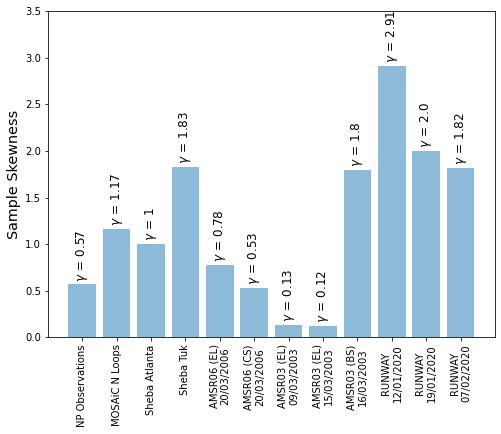

In [37]:
fig, ax = plt.subplots(1,1,figsize=(8,6))

all_sites = site + dates
all_skews = MYI_skew + skews

ax.bar(range(len(all_skews)),all_skews,alpha=0.5)

# ax.bar([len(CVs+1)], [statistics['all']['stats']],color='r',alpha=0.5)

ax.set_xticks(range(len(all_skews)))
ax.set_xticklabels(all_sites,rotation=90)
ax.set_ylabel('Sample Skewness',fontsize='x-large')

gamma = r'$\gamma$'

for i, x in zip(all_skews,np.arange(len(all_skews))):
    
    ax.annotate(f' {gamma} = {np.round(i,decimals=2)}',rotation=90,xy=(x,i),
                  xycoords='data',va='bottom',ha='center', fontsize='large')
    
ax.set_ylim(0,3.5)

plt.savefig('/home/robbie/Dropbox/Apps/Overleaf/sub-km-snow-depth-dist/sup_figs/sample_skewness.png', bbox_inches='tight',dpi=500)


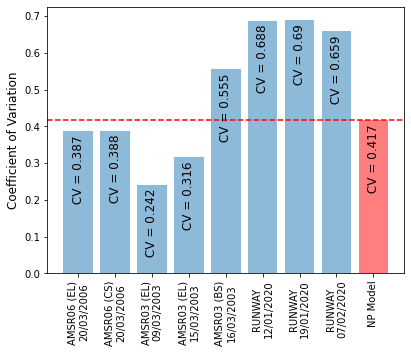

In [49]:
CVs = np.divide(np.array([x[1] for x in elson_ratios]),
          np.array([x[0] for x in elson_ratios]))

fig, ax = plt.subplots(1,1,figsize=(6.4,4.9))

ax.bar(range(len(CVs)),CVs,alpha=0.5)
ax.bar([len(CVs+1)], [statistics['all']['stats']],color='r',alpha=0.5)

ax.set_xticks(range(len(CVs)+1))
ax.set_xticklabels(dates+['NP Model'],rotation=90)
ax.axhline(statistics['all']['stats'],color='r',ls='--')
ax.set_ylabel('Coefficient of Variation',fontsize='large')

for i, x in zip(list(CVs)+[statistics['all']['stats']],
                np.arange(len(CVs)+1)):
    
    ax.annotate(f' CV = {np.round(i,decimals=3)} ',rotation=90,xy=(x,i),
                  xycoords='data',va='top',ha='center', fontsize='large')

plt.savefig('/home/robbie/Dropbox/Apps/Overleaf/sub-km-snow-depth-dist/sup_figs/FYI_CV.png', bbox_inches='tight',dpi=500)


In [10]:
CVs

array([0.38659481, 0.38784249, 0.24194242, 0.31580658, 0.55540596,
       0.68759141, 0.69032376, 0.65860929])

In [34]:
np.mean(CVs-statistics['all']['stats'])/statistics['all']['stats']

0.17640210896368586

In [26]:
statistics['all']

{'a': 2.542562886886376,
 'loc': -1.1145255608199975,
 'scale': 1.497381943420248,
 'stats': 0.4169616718934025,
 'n': 33539}

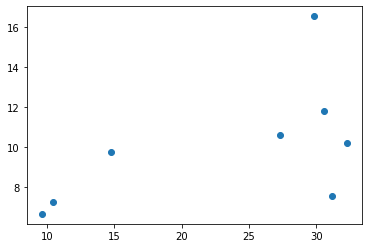

In [24]:
plt.scatter([x[0] for x in elson_ratios], [x[1] for x in elson_ratios])

In [64]:
best_pdf

array([1.59616317e-27, 8.20598599e-17, 4.28122776e-09, 2.56399969e-04,
       2.84794397e-02, 5.46013341e-02, 5.44036177e-02, 5.37583187e-02,
       5.28694892e-02, 5.17494944e-02, 5.04137110e-02, 4.88801786e-02,
       4.71691944e-02, 4.53028678e-02, 4.33046457e-02, 4.11988264e-02,
       3.90100727e-02, 3.67629399e-02, 3.44814300e-02, 3.21885833e-02,
       2.99061162e-02, 2.76541127e-02, 2.54507745e-02, 2.33122308e-02,
       2.12524120e-02, 1.92829813e-02, 1.74133244e-02, 1.56505918e-02,
       1.39997859e-02, 1.24638894e-02, 1.10440239e-02, 9.73963423e-03,
       8.54868900e-03, 7.46789061e-03, 6.49288839e-03, 5.61848838e-03,
       4.83885487e-03, 4.14769932e-03, 3.53845351e-03, 3.00442441e-03,
       2.53892944e-03, 2.13541131e-03, 1.78753274e-03, 1.48925146e-03,
       1.23487677e-03, 1.01910931e-03, 8.37065560e-04, 6.84289286e-04,
       5.56751718e-04, 4.50842606e-04, 3.63353960e-04, 2.91458283e-04,
       2.32682900e-04, 1.84881771e-04, 1.46206027e-04, 1.15074215e-04,
      

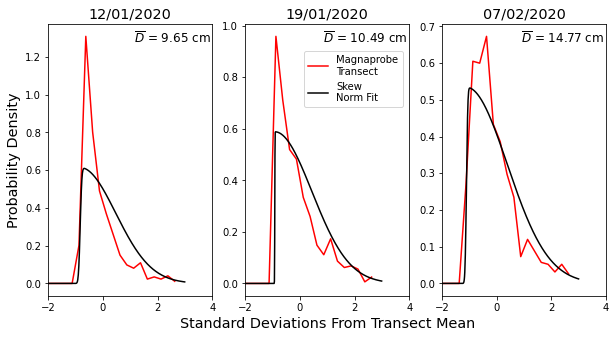

In [123]:
runway_paths = [
                '../AMSR snow depth/mosaic_runway_20200112.xls',
                '../AMSR snow depth/mosaic_runway_20200119.xls',
               '../AMSR snow depth/mosaic_runway_20200207.xls',
               ]

t_dates =       ['12/01/2020',
                 '19/01/2020',
                 '07/02/2020']


fig, axs = plt.subplots(1,3,figsize=(10,5))

for axr, epath, t_date in zip(axs.reshape(-1), runway_paths, t_dates):
    
    df = pd.read_excel(epath)
    
    d_bar = np.nanmean(df['Snow Depth (cm)'])
    
    snod = df['Snow Depth (cm)'] - d_bar
    
    snod_sd = np.nanstd(snod)
    
    nas = snod/snod_sd
    
    x = np.arange(-3,3,0.25)
    xhi = np.arange(-3,3,0.01)
    
    h, be = np.histogram(nas,density=True,bins=x)
    
    axr.plot((be[:-1]+be[1:])/2,h,color='r')
    
    ft = skewnorm.fit(nas)
    
    best_pdf = skewnorm.pdf(xhi,ft[0],ft[1],ft[2])

    axr.plot(xhi,best_pdf,color='k')
    
    axr.set_xlim(-2,4)
    
    axr.set_title(t_date, fontsize='x-large')
    
    dbr = np.round(d_bar,decimals=2)
    dbr_sym = r'$\overline{D}$'
    axr.annotate(f'{dbr_sym} = {dbr} cm',
                 xycoords='axes fraction', xy=(0.99,0.98),
                 ha='right',va='top', fontsize='large')
    
ax1, ax2, ax3 = axs.reshape(-1)

ax2.plot([],[],color='r', label='Magnaprobe\nTransect')
ax2.legend()
ax2.plot([],[],color='k', label='Skew\nNorm Fit')
ax2.legend(loc='upper right',bbox_to_anchor=(0.99,0.92))


ax2.set_xlabel('Standard Deviations From Transect Mean', fontsize='x-large')

ax1.set_ylabel('Probability Density', fontsize='x-large')

plt.savefig(f'/home/robbie/Dropbox/Apps/Overleaf/sub-km-snow-depth-dist/sup_figs/runway.png', 
            bbox_inches='tight',dpi=500)

In [86]:
ft

(38.41966217244335, -1.1089390731279551, 1.493233260364367)

In [56]:
ft

(38.419589066368985, 3.9825002514045225, 14.525230090554567)

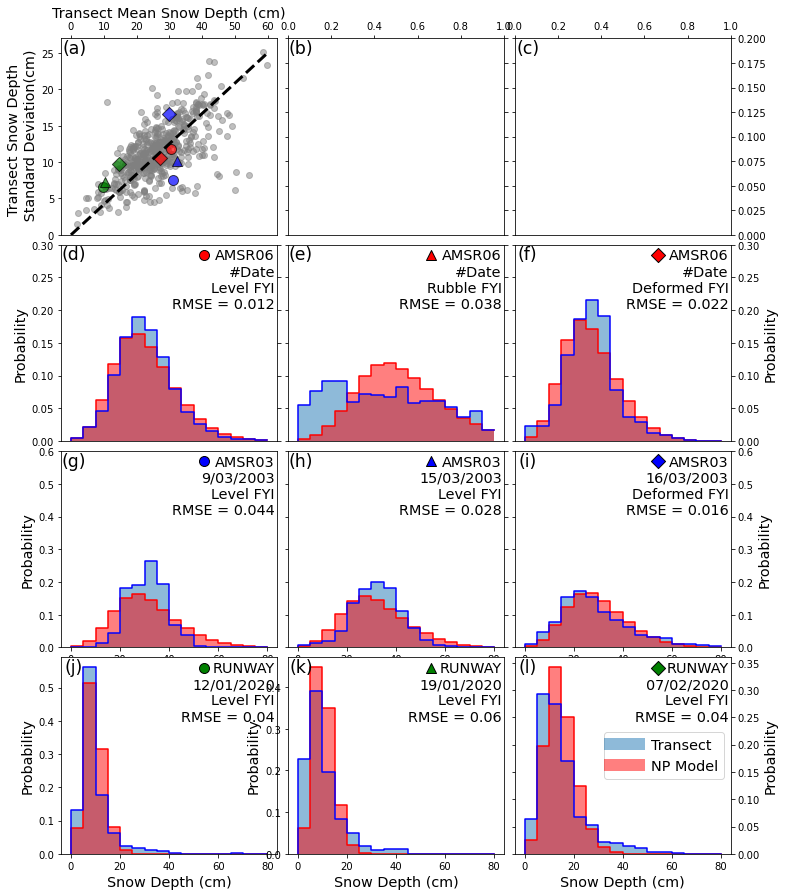

In [41]:
fig, axs = plt.subplots(4,3,figsize=(12,15))

ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12 = axs.reshape(-1)

###############

ax1.scatter(np_df['mean'], np_df['std'],marker='o',color='gray',alpha=0.5, label = 'NP Transects')
ax1.plot([0,np.max(np_df['mean'])], linear_prediction, color='k',lw=3, ls='--')

ax1.set_ylabel('Transect Snow Depth \n Standard Deviation(cm)', fontsize='x-large')

ax1.set_xlabel('Transect Mean Snow Depth (cm)', fontsize='x-large')

#######################################

elson_paths = [
               '../AMSR snow depth/AMSRIce2006_Elson.xlsx',
               '../AMSR snow depth/AMSRIce2006_Chukchi_rubble.xlsx',
               '../AMSR snow depth/AMSRIce2006_Chukchi_smooth.xlsx',
               '../AMSR snow depth/MP3Mar9Elson.xls',
               '../AMSR snow depth/GPSMagnaProbeMar15Elson.xls',
               '../AMSR snow depth/GPSMagnaProbe2Mar16Elson.xls',
                '../AMSR snow depth/mosaic_runway_20200112.xls',
                '../AMSR snow depth/mosaic_runway_20200119.xls',
               '../AMSR snow depth/mosaic_runway_20200207.xls',


               ]

dates = ['AMSR06\n#Date',
         'AMSR06\n#Date',
         'AMSR06\n#Date',
         'AMSR03\n9/03/2003',
         'AMSR03\n15/03/2003',
         'AMSR03\n16/03/2003',
        'RUNWAY\n12/01/2020',
         'RUNWAY\n19/01/2020',
         'RUNWAY\n07/02/2020']

elson_ratios = []

rmses = []

for ax, epath in zip(axs.reshape(-1)[3:], elson_paths):
    
    df = pd.read_excel(epath)
    
    elson_ratios.append( (np.nanmean(df['Snow Depth (cm)']), 
                           np.nanstd(df['Snow Depth (cm)'])) )

    _,_,_,rmse,bp = compare_magna(df, ax=ax, impose_y=True,anno=False,season='all')   
    rmses.append(rmse)
    
    
    ax.set_xlabel('Snow Depth (cm)', fontsize='x-large')
    ax.set_ylabel('Probability', fontsize='x-large')
    

ice_types = ['Level FYI', 'Rubble FYI', 'Deformed FYI',
             'Level FYI','Level FYI', 'Deformed FYI',
            'Level FYI', 'Level FYI','Level FYI',]
    
dates = ['AMSR06\n#Date','AMSR06\n#Date','AMSR06\n#Date',
         'AMSR03\n9/03/2003','AMSR03\n15/03/2003','AMSR03\n16/03/2003',
        'RUNWAY\n12/01/2020','RUNWAY\n19/01/2020','RUNWAY\n07/02/2020']

####

line1, = plt.plot([], lw=12, label="Transect", color='#1f77b4',alpha=0.5,)
line2, = plt.plot([], lw=12, label="NP Model", color='r',alpha=0.5,)
first_legend = ax12.legend(handles=[line1,line2], loc='center right', fontsize='x-large')
lax = plt.gca().add_artist(first_legend)

###

for i, marker, date, color in zip(range(9),
                                 ['o','^','D','o','^','D','o','^','D'],
                                 dates,
                                 ['r','r','r','b','b','b','g','g','g']):
    
    ax1.scatter([x[0] for x in [elson_ratios[i]]],
                [x[1] for x in [elson_ratios[i]]],
                marker=marker,color=color,s=100,
                label = date, edgecolors='k',alpha=0.7)
    
    ax = axs.reshape(-1)[i+3]
    line = ax.scatter([],[],
               marker=marker,color=color,s=100,
               label = '',edgecolors='k')
    l = ax.legend([line], [''], bbox_to_anchor=(0.68,0.95),
                  loc='center',frameon=False)
    l.get_frame().set_linewidth(0.0)
    
ax1.set_ylim(0,27)


for ax in [ax1,ax2,ax3]:
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    
for ax in [ax4,ax5,ax6]:
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.set_ylim(0,0.3)
    ax.yaxis.set_ticks_position('both')
    
for ax in [ax2,ax3]:
    ax.set_ylim(0,0.2)
    ax.yaxis.set_ticks_position('both')

for ax in [ax7,ax8,ax9]:
    ax.set_ylim(0,0.6)
    
    
for ax in [ax2,ax5,ax8,]:
    ax.yaxis.set_ticks_position('both')
    ax.set_yticklabels([])
    ax.set_ylabel('')
    
for ax in [ax3,ax6,ax9,ax12]:
    ax.yaxis.tick_right()
    ax.yaxis.set_ticks_position('both')
    ax.yaxis.set_label_position('right')
    
for ax, letter in zip(axs.reshape(-1),
                      alphabet_string):
    ax.annotate(xy=(0.06,0.95),xycoords='axes fraction',
                text=f'({letter})', fontsize='xx-large',
                ha='center',va='center')
    
for ax, date, it, rmse in zip(axs.reshape(-1)[3:],
                              dates,
                             ice_types,
                             rmses):
    
    ax.annotate(xy=(0.99,0.98),xycoords='axes fraction',
                text=f'{date}\n{it}\nRMSE = {rmse}', fontsize='x-large',
                ha='right',va='top')

plt.subplots_adjust(wspace=0.05,hspace=0.05)

# plt.savefig('../figures/elson_lagoon.png', bbox_inches='tight',dpi=500)
# plt.savefig('/home/robbie/Dropbox/Apps/Overleaf/sub-km-snow-depth-dist/elson_lagoon.png', bbox_inches='tight',dpi=500)

plt.show()

In [110]:
for i in elson_ratios:
    
    print(i)
    
    diff = (i[0] * 0.417) - i[1]
    
    print(diff/i[1])

(31.15610243902439, 7.537982757536718)
0.723550601662395
(32.23609159609121, 10.18036973241023)
0.32042848628322823
(29.793142009309545, 16.54728877029319)
-0.24919783595086484


In [ ]:
# # ax2.plot((tiny_bin_edges * depth_std)+depth_mean, np_fit*(2*0.05), color='k',lw=3, ls='--', label='NP Model')
# ax2.plot(bin_edges, np_fit, color='k',lw=3, ls='--', label='NP Model')
# ax2.plot(bin_edges, amsr_fit, color='red',lw=3, label='Best Skew-\n Normal Fit')

# ax2.hist(depth, bins = bin_edges, density=True,color='gray')

# ax2.set_xlabel('Snow Depth (cm)', fontsize='x-large')

# ax2.legend(fontsize='large')

# ax2.yaxis.set_ticks_position('right')
# ax2.yaxis.set_label_position("right")

# ax2.set_ylabel(r'Probability Density (cm$^{-1}$)', fontsize='x-large')


# ax1.annotate(text='(a)', fontsize='xx-large', xy=(-0.1,1.05), xycoords= 'axes fraction')

# ax2.annotate(text='(b)', fontsize='xx-large', xy=(-0.1,1.05), xycoords= 'axes fraction')


#######################################################################

# plt.savefig('../figures/elson_lagoon.png', bbox_inches='tight',dpi=500)
# plt.savefig('/home/robbie/Dropbox/Apps/Overleaf/sub-km-snow-depth-dist/elson_lagoon.png', bbox_inches='tight',dpi=500)

In [17]:
df = pd.read_excel('../AMSR snow depth/GPSMagnaProbeMar15Elson.xls')

depth = np.array(df['Snow Depth (cm)'])

depth_mean = np.mean(depth)

depth_std = np.std(depth)

rel_normed_depth = (depth-depth_mean)/depth_std
                   

amsr_fit_stats = skewnorm.fit(depth)
amsr_fit = skewnorm.pdf(bin_edges,amsr_fit_stats[0],amsr_fit_stats[1],amsr_fit_stats[2])
amsr_fit_stats

(0.8447588819980191, 26.13185806422102, 11.870198310120132)

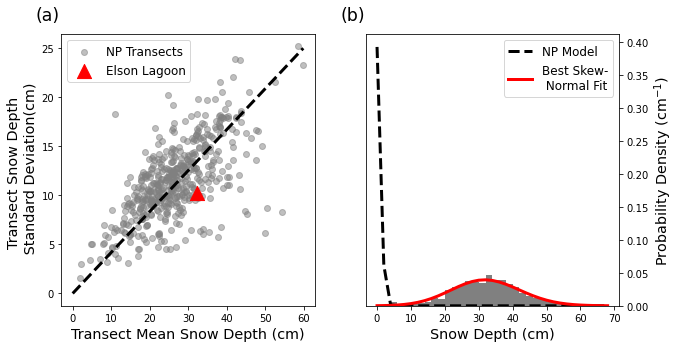

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))

ax1.scatter(np_df['mean'], np_df['std'],marker='o',color='gray',alpha=0.5, label = 'NP Transects')
ax1.scatter([depth_mean], [depth_std],marker='^',color='red',s=200, label = 'Elson Lagoon')
ax1.plot([0,np.max(np_df['mean'])], linear_prediction, color='k',lw=3, ls='--')

ax1.set_ylabel('Transect Snow Depth \n Standard Deviation(cm)', fontsize='x-large')

ax1.set_xlabel('Transect Mean Snow Depth (cm)', fontsize='x-large')

ax1.legend(fontsize='large')

#######################################

# ax2.plot((tiny_bin_edges * depth_std)+depth_mean, np_fit*(2*0.05), color='k',lw=3, ls='--', label='NP Model')
ax2.plot(bin_edges, np_fit, color='k',lw=3, ls='--', label='NP Model')
ax2.plot(bin_edges, amsr_fit, color='red',lw=3, label='Best Skew-\n Normal Fit')

ax2.hist(depth, bins = bin_edges, density=True,color='gray')

ax2.set_xlabel('Snow Depth (cm)', fontsize='x-large')

ax2.legend(fontsize='large')

ax2.yaxis.set_ticks_position('right')
ax2.yaxis.set_label_position("right")

ax2.set_ylabel(r'Probability Density (cm$^{-1}$)', fontsize='x-large')


ax1.annotate(text='(a)', fontsize='xx-large', xy=(-0.1,1.05), xycoords= 'axes fraction')

ax2.annotate(text='(b)', fontsize='xx-large', xy=(-0.1,1.05), xycoords= 'axes fraction')


#######################################################################

plt.savefig('../figures/elson_lagoon.png', bbox_inches='tight',dpi=500)
plt.savefig('/home/robbie/Dropbox/Apps/Overleaf/sub-km-snow-depth-dist/elson_lagoon.png', bbox_inches='tight',dpi=500)


In [7]:
all_statistics['a']

2.542562886886376

In [8]:
np_df['ratio'] = np_df['std']/np_df['mean']

np_df

,std,mean,norm,ratio
0,9.920743,20.584158,"[0.9491065230262345, 1.7554977644617735, 0.646...",0.481960
1,12.285984,25.693069,"[-0.30059207078844336, -0.13780494398076085, 2...",0.478183
2,11.546287,27.009901,"[-0.6071130267771289, -1.2133685492791488, -1....",0.427483
3,12.960067,31.237624,"[-0.558455736090968, -0.7127759258178838, -1.3...",0.414886
4,7.380496,23.940594,"[0.4145258012114489, 1.904940575146465, -0.669...",0.308284
...,...,...,...,...
494,12.085090,18.009901,"[0.9921397969281626, -0.24905904068221413, 1.7...",0.671025
495,14.978534,49.197802,"[-1.214925458198433, 0.5876541618459813, 0.721...",0.304455
496,15.843113,46.188119,"[-2.22103571509425, 0.5561963383325499, 0.8717...",0.343013
497,17.435291,43.637363,"[-1.1836546119648217, -0.4380404447899632, 1.3...",0.399550


In [9]:
depth.shape

(1535,)